## Imports and dataset

In [2]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import time
from joblib import Parallel, delayed

ModuleNotFoundError: No module named 'src.utils'

In [2]:
# Wine dataset with response in {0, 1, 2}, 13 features and 178 samples
# X, y = load_wine(return_X_y=True)

In [3]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]  # TODO: ATACAMOS INTERCEPTO ?????

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [5]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [6]:
def kl_div(mu_n, lam_n, sigma2, x, x_adv):
    sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2
    mu_A = x_adv.T @ mu_n
    sigma2_D = x.T @ torch.inverse(lam_n) @ x + sigma2
    mu_D = x.T @ mu_n
    kl = 0.5 * (torch.log(sigma2_A / sigma2_D) + (sigma2_D + (mu_D - mu_A)**2) / sigma2_A - 1)
    return kl

In [7]:
# kl maximization to find adversarial attacked to a trained model
def kl_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3):
    x_adv_values = []
    kl_values = []
    
    mu_n = model.mu
    lam_n = model.lam
    sigma2 = model.sigma2
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
        kl.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        kl_values.append(-kl.detach().item())

    return x_adv.detach(), x_adv_values, kl_values 

In [8]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values, kl_values = kl_maximization(model, x, epsilon=0.3)

Text(0, 0.5, 'KL Divergence')

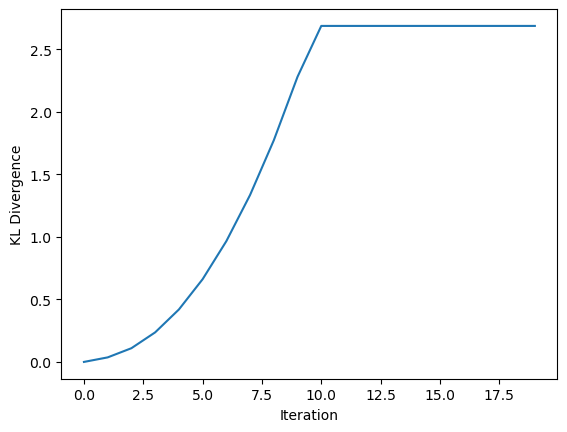

In [9]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

Text(0.5, 0, 'y')

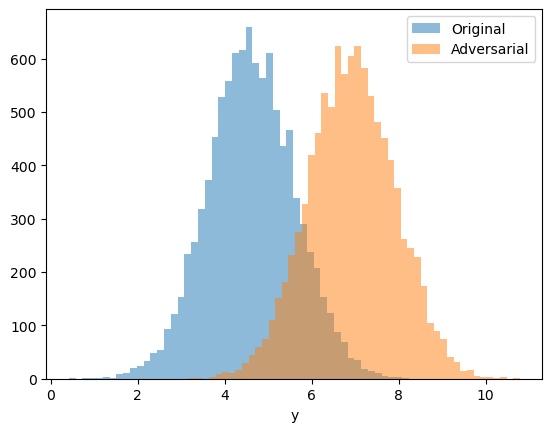

In [10]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    x_adv_distr,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

Text(0, 0.5, 'KL Divergence')

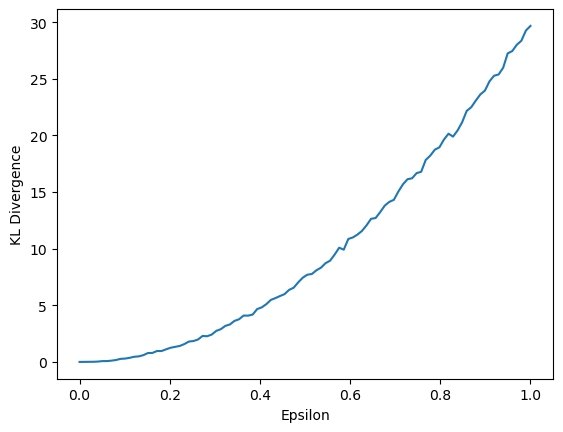

In [11]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# plot KL divergence as a function of the strength of the attack
epsilons = np.linspace(0, 1, 100)
kl_values = []
for epsilon in epsilons:
    x_adv_distr, _, kl = kl_maximization(model, x, epsilon=epsilon)
    kl_values.append(kl[-1])

plt.plot(epsilons, kl_values)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

### Attack definition

In [12]:
# Function pi(y | x, gamma)
def pi(y, x, gamma):
    return torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1]).log_prob(y).exp()

# Gradient of pi(y | x, gamma) with respect to x
# pi(y | x, gamma) is Normal(x.T @ beta, sigma2) with beta = gamma[0] and sigma2 = gamma[1]
def grad_pi(y, x, gamma):
    distr = torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1])
    prob = distr.log_prob(y).exp()
    grad = (y - x.T @ gamma[0]) / gamma[1] * prob * gamma[0]
    return grad


In [13]:
# g_{x, M}(y)
def g_x_M(y, x, gamma_samples): 
    # betas and sigmas shape: (D, M) and (1, M)
    grad_pi_vals = grad_pi(y, x, gamma_samples) 
    pi_vals = pi(y, x, gamma_samples) 
    numerator = torch.mean(grad_pi_vals, dim=1, keepdim=True)  # Promedio sobre M (segunda dimensión)
    denominator = torch.mean(pi_vals, dim=1)  # Promedio sobre M (segunda dimensión)
    return numerator / denominator  # not - since max disruption problem

In [14]:
# Compute Δg_{x', l}(y)
def delta_g_x_l(y, x, l, model, M_sequence):
    M_l = M_sequence[l]
    M_l_minus_1 = M_sequence[l-1] if l > 0 else 0
    gamma_samples_l = model.sample_posterior_distribution(M_l)
    
    # using the same samples for both terms in the difference
    gamma_samples_l_minus_1_a = [gamma_samples_l[0][:, :M_l_minus_1], gamma_samples_l[1][:, :M_l_minus_1]]
    gamma_samples_l_minus_1_b = [gamma_samples_l[0][:, M_l_minus_1:], gamma_samples_l[1][:, M_l_minus_1:]]

    g_l = g_x_M(y, x, gamma_samples_l)
    g_l_minus_1_a = g_x_M(y, x, gamma_samples_l_minus_1_a) if l > 0 else 0
    g_l_minus_1_b = g_x_M(y, x, gamma_samples_l_minus_1_b) if l > 0 else 0
    return g_l - (g_l_minus_1_a + g_l_minus_1_b) / 2

In [15]:
# Estimate the gradient using MLMC
def mlmc_gradient_estimator(y, x, R, model, M0=1, tau=1.):
    # Define sequence M_l
    M_sequence = [M0*2**l for l in range(100)]

    # Define weights ω_l
    omega = [2**(-tau * l) for l in range(len(M_sequence))]
    omega = np.array(omega)
    omega /= omega.sum()  # Normalize

    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    
    estimates = [delta_g_x_l(y, x, l, model, M_sequence) / omega[l] for l in l_indices]
    return sum(estimates) / R

In [16]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, lr=0.01, n_iter=100, epsilon=.1, R=100, early_stopping_patience=10):
    x_adv_values = []
    patience = 0
    x_adv = (x + torch.randn_like(x) * 0.01).clone().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)

    for it in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        y = model.sample_predictive_distribution(x, num_samples=1)
        start = time.time()
        x_adv.grad = mlmc_gradient_estimator(y, x_adv, R, model)
        if time.time() - start > 2:
            print(f'Long gradient estimation time: {time.time() - start} for iteration {it}')
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

        if it > 2 and np.linalg.norm(x_adv_values[-1] - x_adv_values[-2]) < 1e-3:
            patience += 1
            if patience >= early_stopping_patience:
                break
        else:
            patience = 0

    return x_adv.detach().numpy(), x_adv_values

### Case 2a: NormalInverseGamma model

In [17]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

c:\users\pgarc\desktop\advreg\src\models\conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\aten\src\ATen\native\TensorShape.cpp:3679.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


In [18]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3, R=100)

Text(0.5, 0, 'y')

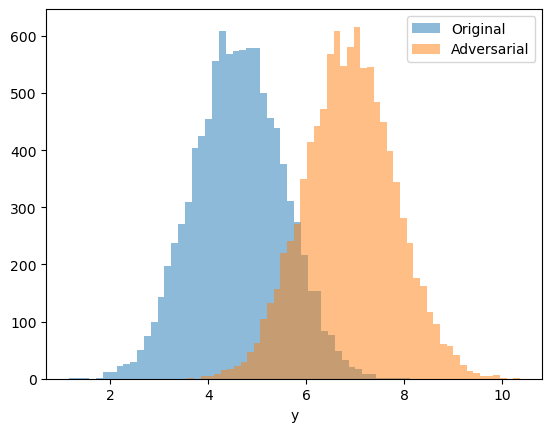

In [19]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

0
1
2
Long gradient estimation time: 13.47544002532959 for iteration 10
3
Long gradient estimation time: 2.076615333557129 for iteration 12
4
Long gradient estimation time: 2.2141644954681396 for iteration 10
Long gradient estimation time: 2.0628395080566406 for iteration 15
5
6
7
Long gradient estimation time: 2.1315150260925293 for iteration 20
Long gradient estimation time: 3.876004457473755 for iteration 35
8
9


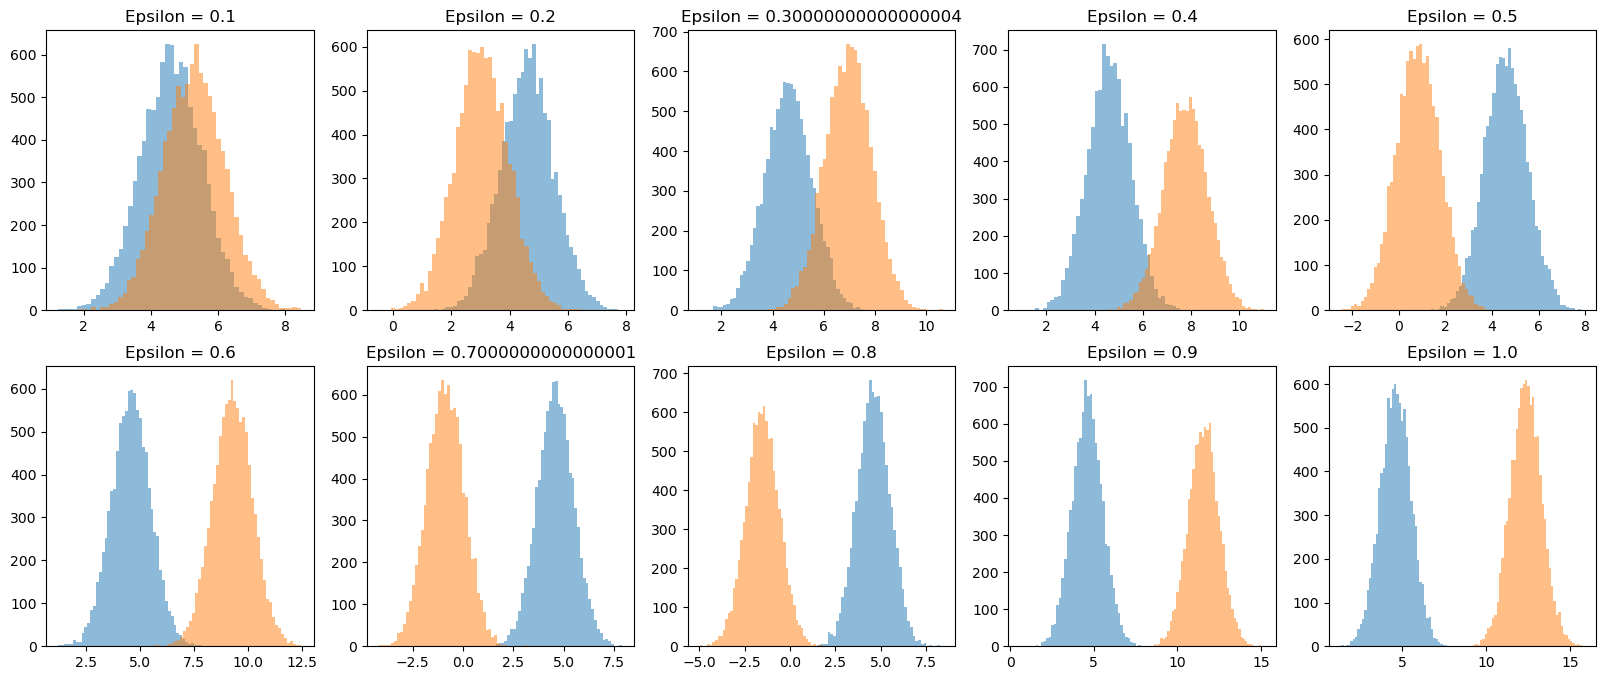

In [55]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    print(i)
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]
    ax.hist(model.sample_predictive_distribution(
        x,
        num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
    ax.hist(model.sample_predictive_distribution(
        torch.tensor(x_adv_distr, dtype=torch.float32),
        num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
    ax.set_title(f'Epsilon = {epsilon}')

C:\Users\pgarc\AppData\Local\Temp\ipykernel_8644\1901980804.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)


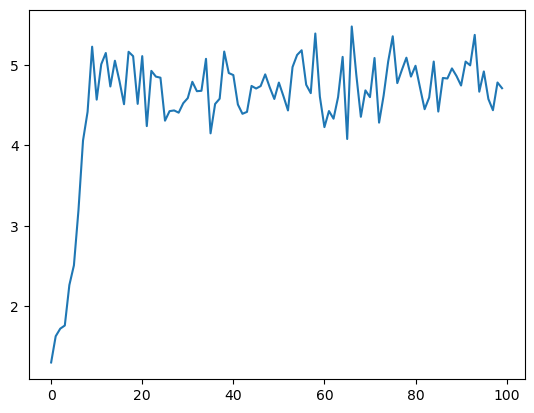

In [53]:
# Plot values evolution for the adversarial attack
kl_proxies = []
for x_adv in x_adv_values:
    y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, torch.tensor(x_adv, dtype=torch.float32), model.sample_posterior_distribution(100))))
    kl_proxies.append(val.item())

plt.plot(kl_proxies)

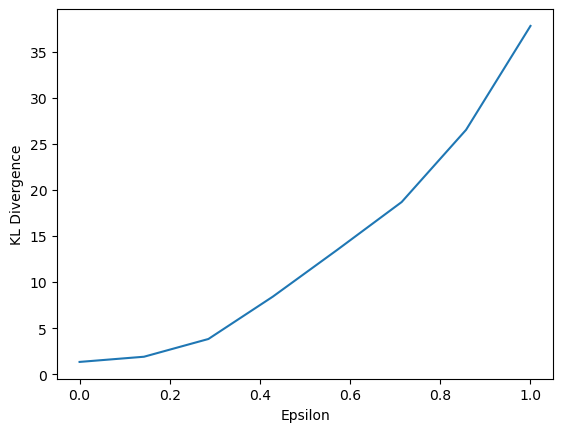

In [20]:
n_jobs = -1

# queremos maximizar E_y[ -\log \pi(y | x', D)] con y \sim p(y | x, D)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, torch.tensor(x_adv_distr, dtype=torch.float32), model.sample_posterior_distribution(100))))
    return val

# Define the range of epsilon values
epsilons = np.linspace(0, 1, 8)

# Use joblib to parallelize the computation of KL divergences
kl_values = Parallel(n_jobs=n_jobs)(
    delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons
)

# Plotting the results
plt.plot(epsilons, kl_values)
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')
plt.show()

### Case 2b: Same model as case 1

In [88]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [89]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = Adam([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

0
1
2
3
4


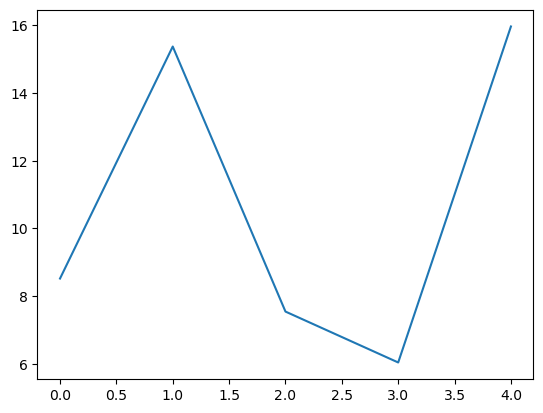

In [23]:
# check gradient estimation   ??????????????????????????
# TODO: La estimación es buena en dirección pero no en magnitud. ¿Por qué? algo proporcional a beta pero nada mas?

norms = []
for it in range(5):
    print(it)
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.plot(norms)

0
1
2
3
4


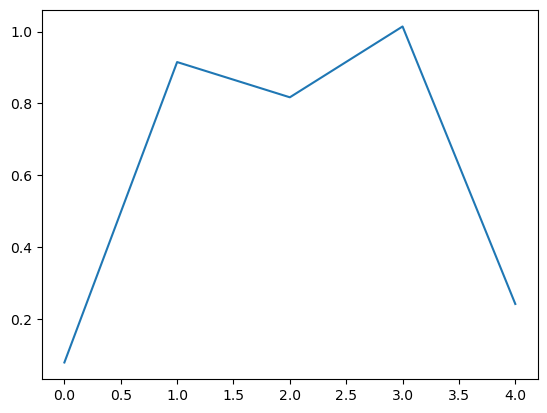

In [92]:
# same as before but estimate the gradient doing the mean of 100 iterations
norms = []
for it in range(5):
    print(it)
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate += mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    gradient_estimate /= 101
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms)

In [24]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3)

Text(0.5, 0, 'y')

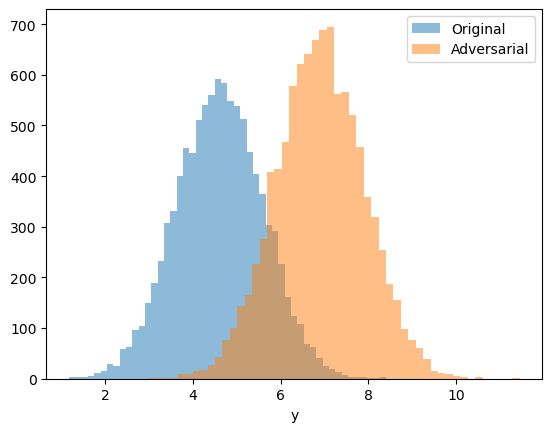

In [25]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

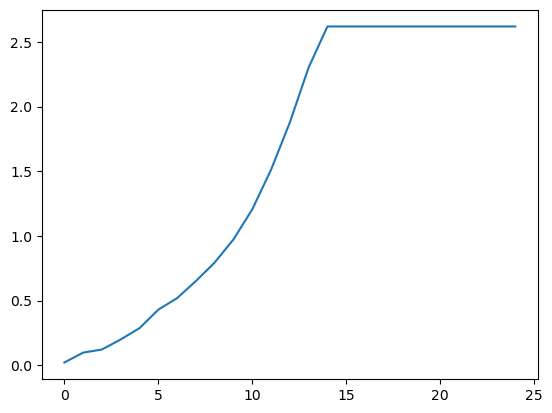

In [26]:
# plot KL evolution
kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]

plt.plot(kl_values)

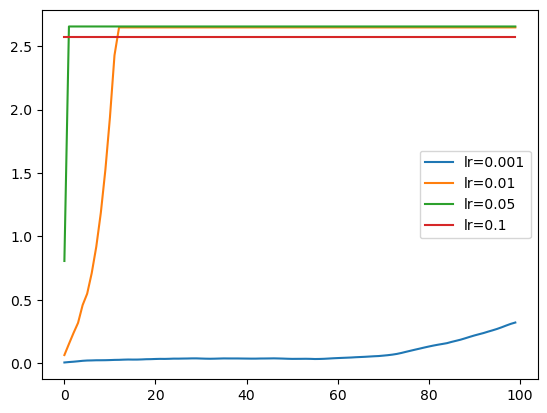

In [27]:
# plot kl evolution for different learning rates with joblib
lrs = [0.001, 0.01, 0.05, 0.1]

n_jobs = -1

def kl_values(lr):
    x = X_test[17,:].copy()
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    x_adv_distr, x_adv_values = mlmc_attack(model, x, lr=lr, epsilon=0.3, early_stopping_patience=100)
    kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]
    return kl_values    

kl_values_list = Parallel(n_jobs=n_jobs)(
    delayed(kl_values)(lr) for lr in lrs
)

for kls, lr in zip(kl_values_list, lrs):
    plt.plot(kls, label=f'lr={lr}')
plt.legend()

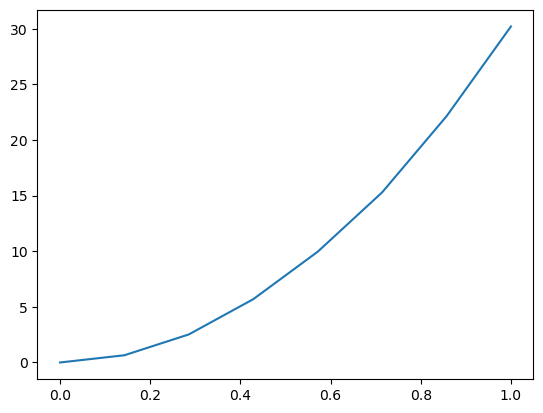

In [28]:
# plot KL divergence as a function of the strength of the attack
n_jobs = -1

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    max_kl = 0
    for _ in range(10):
        x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
        kl = kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv_distr, dtype=torch.float32)).item()
        if kl > max_kl:
            max_kl = kl
    return max_kl


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 8)

# Use joblib to parallelize the computation of KL divergences
kl_values = Parallel(n_jobs=n_jobs)(
    delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
)

# Plotting the results
plt.plot(epsilons, kl_values)

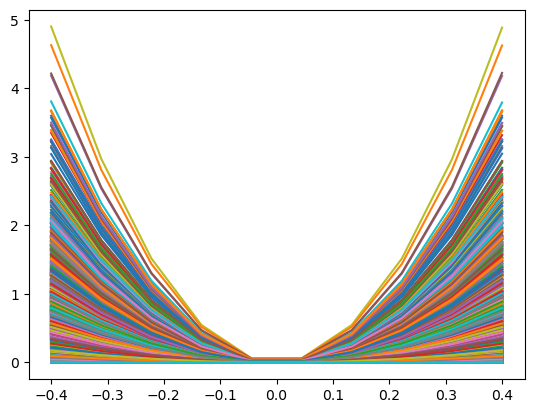

In [29]:
# For random directions (no attack), plot the KL divergence as a function of the strength of the attack
n_directions = 2000
n_values_per_direction = 10
kl_lists = []
eps_max = .4

for _ in range(n_directions):
    direction = torch.randn_like(x)
    direction /= torch.norm(direction, p=2)
    kl_values = []
    for epsilon in np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction):
        x_adv = x + epsilon * direction
        kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv).item()
        kl_values.append(kl)
    kl_lists.append(kl_values)

# represent each line in a different color
for kl_values in kl_lists:
    plt.plot(np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction), kl_values)


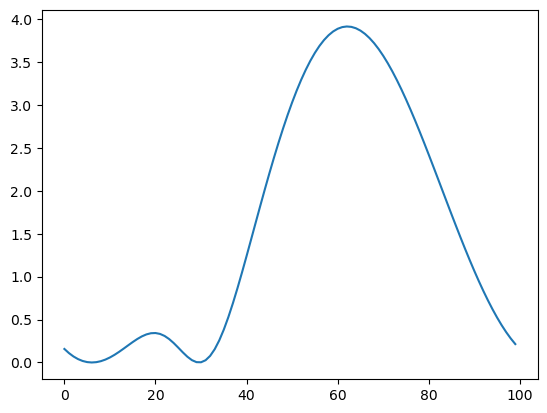

In [36]:
kl_values = []
num_ite = 100

original_point = torch.randn_like(x)
original_point /= torch.norm(original_point, p=2)
original_point = x + eps_max * original_point

direction = torch.randn_like(x)
direction /= torch.norm(direction, p=2)

ortogonal_direction = torch.randn_like(x)
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)
ortogonal_direction = ortogonal_direction - ortogonal_direction.T @ direction * direction
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)

for it in range(num_ite):
    border_point = original_point + direction * np.cos(2 * it * np.pi / num_ite) + ortogonal_direction * np.sin(2 * it * np.pi / num_ite)
    border_point /= torch.norm(border_point, p=2)
    border_point = x + eps_max * border_point

    kl = kl_div(model.mu, model.lam, model.sigma2, x, border_point).item()
    kl_values.append(kl)

plt.plot(kl_values)

### 2c Just backprop of E_y[ -\log \pi(y | x', D)] ? In theory biased

In [69]:
# queremos maximizar E_y[ -\log \pi(y | x', D)] ~ E_y[E_{Gamma|D}[-log \pi(y | x', Gamma)]] con y \sim p(y | x, D)

# Function to calculate kl proxy
def kl_proxy(model, x, x_adv, num_samples=100):
    y_samples = model.sample_predictive_distribution(x, num_samples=num_samples)
    return -torch.mean(torch.log(pi(y_samples, x_adv, model.sample_posterior_distribution(num_samples))))

def proxy_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3, num_samples=100):
    x_adv_values = []
    proxy_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        proxy = - kl_proxy(model, x, x_adv, num_samples=num_samples)  # maximum disruption problem
        proxy.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        proxy_values.append(-proxy.detach().item())

    return x_adv.detach(), x_adv_values, proxy_values 

In [66]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [86]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_proxy, x_adv_values, proxy_values = proxy_maximization(model, x, epsilon=0.3, num_samples=100)

Text(0.5, 0, 'y')

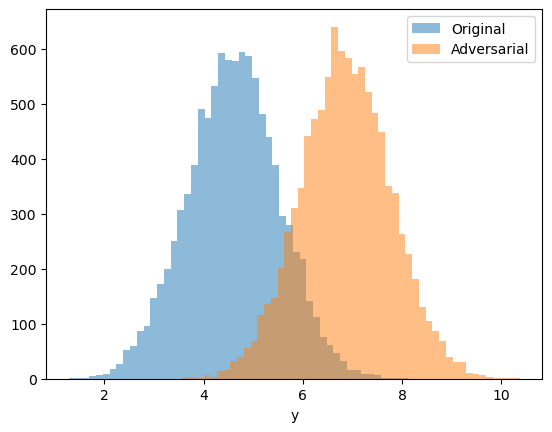

In [87]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    x_adv_proxy,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

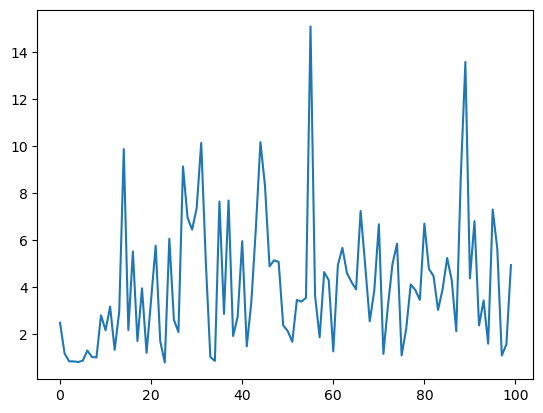

In [64]:
plt.plot(proxy_values)